# Overview

The transformer is a general and powerful neural network architecture, able to tackle many real-world problems. Vision transformer (ViT) is a transformer for computer vision tasks. In this notebook, Vision Transformer (ViT) is implemented from scratch using PyTorch for image classification. Later, we will train the model on a subset of RSNA breast cancer detection dataset.

# 1. About the Architecture
Transformers found their initial applications in natural language processing (NLP) tasks. To use this NLP model for computer vision tasks, we have to divide our input image into patches. After flattening the patches, we can treat each flattened patches as single word. We add positional embeddings to the linear projection of flattened patches. An extra token is added at the beginning for classification tasks. In BERT model, this token is called [CLS] token.

So if our input image size is (512, 512), after dividing the image into patches of size (16, 16), we get 1024 (32 times 32) patches. After flattening the patches and projecting the flattened patches, we have 1024 tokens. After adding positional embeddings and concatenating classification token at the beginning, we have 1025 tokens.

We then feed our tokens into the transformer encoder. Transformer encoder is made up of self attention and feedforward network. The [original paper](https://paperswithcode.com/paper/attention-is-all-you-need) on attention is an excellent read if you want to understand the whole attention mechanism. PyTorch have `torch.nn.MultiHeadAttention` for anyone who one to use attention mechanism for their next project. This [video](https://www.youtube.com/watch?v=_UVfwBqcnbM) by AssemblyAI is explains the transformer architecture beautifully.

The number of tokens in the output of the transformer encoder is equal to number of input tokens. We take the first token from the output (corresponds to the classification token) and feed the token in a multilayer perceptron head for classification.

For more details, you can go through [original paper](https://paperswithcode.com/method/vision-transformer) on Vision Transformer.

![Vision Transformer](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

# 2. About the Dataset
The dataset was contributed by mammography screening programs in Australia and the U.S. It includes detailed labels, with radiologists’ evaluations and follow-up pathology results for suspected malignancies. 

The dataset is stored in dicom formats. Converting dicom data to png/jpg just by rescaling it will harm the quality of the data. [This notebook](https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way/notebook) is an awesome resource for anyone working with dicom files for X-Ray.

# 3. Implementation

## 3.1 Utility functions
We write some utility functions beforehand.

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

In [2]:
def read_xray(file_path, img_size=None):
    """
    Read the dicom data and get the image
    Args:
        file_path: The path of the dicom file
        img_size: Size of the output image
    """

    dicom = pydicom.read_file(file_path)
    img = dicom.pixel_array

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = np.max(img) - img

    if img_size:
        img = cv2.resize(img, img_size)

    # Add channel dim at First
    img = img[np.newaxis]

    # Converting img to float32
    img = img / np.max(img)
    img = img.astype("float32")

    return img

In [3]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images
        
    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches

We test our `patchify` function on a single image.

<Figure size 360x360 with 0 Axes>

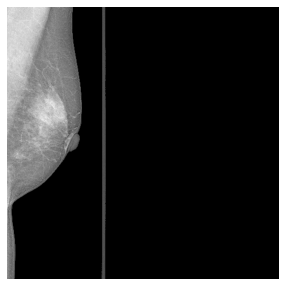

<Figure size 360x360 with 0 Axes>

In [5]:
FILE_PATH = ('/kaggle/input/rsna-breast-cancer-detection/'
             'train_images/10006/1459541791.dcm')

img = read_xray(FILE_PATH, img_size=(512, 512))

batch = torch.tensor(img[None])
patch_size = (16, 16)
batch_patches = patchify(batch, patch_size)

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5, 5))

In [6]:
def get_mlp(in_features, hidden_units, out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1, dim2))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)

## 3.2 Image to Sequence Block
This Block takes a batch of image as input and returns a batch of sequences. Later on we feed this sequences into the transformer encoder.

In [7]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = nn.Linear(token_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

## 3.3 Visual Transformer Module
This modules wraps up everything. We can divide this module into 3 parts: 
* An image to sequence encoder
* Transformer encoder
* Multilayer perceptron head classification

We use `torch.nn.TransformerEncoder` and `torch.nn.TransformerEncoderLayer` to implement our transformer encoder. I highly recommend to read the official documentation to learn more about the layers.

In [8]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            dim_feedforward: The dimension of the feedforward network model in the encoder
            blocks: The number of sub-encoder-layers in the encoder
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)
        
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()

    def __call__(self, batch):

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

# 4. Training

Here, we design a simple training to loop to train or `ViT` model on a subset of dataset. We use an already cropped dataset.

## 4.1 Model Hyperparameters

In [9]:
img_size = (512, 512)
patch_size = (16, 16)
n_channels = 1
d_model = 1024
nhead = 4
dim_feedforward = 2048
blocks = 8
mlp_head_units = [1024, 512]
n_classes = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## 4.2. Dataset and DataLoader

In [10]:
class RSNADataset(Dataset):
    
    def __init__(self, df, img_path):
        self.df = df
        self.img_path = img_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        patient_id, image_id, cancer = self.df.iloc[idx][['patient_id', 'image_id', 'cancer']]
        file = os.path.join(self.img_path, f'{patient_id}_{image_id}.png')
        file = cv2.imread(file, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit = 15, tileGridSize=[8, 8])
        file = clahe.apply(file)
        file = file / file.max()
        X = torch.tensor(file[np.newaxis].astype('float32')).to(device)
        y = torch.tensor([cancer]).float().to(device)
        return X, y

In [11]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
counts = df['cancer'].value_counts()
df['weights'] = df['cancer'].apply(lambda x: 1/counts[x])

train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['cancer'])

In [12]:
img_path = '/kaggle/input/rsna-breast-cancer-512-pngs'
train_samples = 1000
val_samples = 500

train_ds = RSNADataset(train_df, img_path)
val_ds = RSNADataset(val_df, img_path)

train_sampler = WeightedRandomSampler(train_df['weights'].values, train_samples)
train_loader = DataLoader(train_ds, batch_size=8, sampler=train_sampler)

val_sampler = WeightedRandomSampler(val_df['weights'].values, val_samples)
val_loader = DataLoader(val_ds, batch_size=32, sampler=val_sampler)

## 4.3 Training and Validation

In [46]:
model = ViT(
    img_size = (512, 512),
    patch_size = (16, 16),
    n_channels = 1,
    d_model = 1024,
    nhead = 4,
    dim_feedforward = 1024,
    blocks = 8,
    mlp_head_units = [512, 512],
    n_classes = 1,
).to(device)

# 优化器和模型实例化（确保模型在设备上）
optimizer = torch.optim.Adam(model.parameters())
model.to(device)

# 损失函数
criterion = nn.BCELoss() 

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
from ignite.metrics import ThresholdedBinaryAccuracy

# 验证评估器配置
val_metrics = {
    "accuracy": ThresholdedBinaryAccuracy(threshold=0.5),  # 你可以根据需要调整阈值
    "bce": Loss(criterion)
    # 其他度量指标可以继续添加，根据需要调整
}


evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

ImportError: cannot import name 'ThresholdedBinaryAccuracy' from 'ignite.metrics' (/opt/conda/lib/python3.7/site-packages/ignite/metrics/__init__.py)

In [45]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import ProgressBar

# Assuming you have defined your model, optimizer, criterion, train_loader, val_loader, and other necessary components

# Hyperparameters
max_epochs = 10
log_interval = 10
best_loss = float('inf')

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Your model, optimizer, criterion, train_loader, val_loader definitions go here...

# Define the trainer and evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics={'bce': Loss(torch.nn.BCELoss()), 'accuracy': Accuracy()}, device=device)

# Add ProgressBar
pbar = ProgressBar()
pbar.attach(trainer, ['loss'])

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []
epochs = []

# Define training and validation logging functions
def log_training_results(engine):
    loss = engine.state.output
    train_losses.append(loss)
    print(f"Training Results - Epoch: {engine.state.epoch} Avg loss: {loss:.2f}")

def log_validation_results(engine):
    global best_loss
    evaluator.run(val_loader)
    
    # Retrieve metrics
    loss = evaluator.state.metrics['bce']
    accuracy = evaluator.state.metrics['accuracy']
    
    # Save losses and accuracies for plotting
    val_losses.append(loss)
    val_accuracies.append(accuracy)

    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_vit.pt')

    print(f"Validation Results - Epoch: {engine.state.epoch} Avg loss: {loss:.2f} Accuracy: {accuracy:.2%}")

# Attach events to the trainer
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_training_results)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

# Training loop
output_state =trainer.run(train_loader, max_epochs=max_epochs)

# Plot the results after training completes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


[1/125]   1%|           [00:00<?]

Training Results - Epoch: 1 Avg loss: 0.69


ValueError: For binary cases, y_pred must be comprised of 0's and 1's.

In [31]:
log_interval = 10
max_epochs = 5
best_loss = float('inf')

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_vit.pt')
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f}")
    
output_state = trainer.run(train_loader, max_epochs=max_epochs)

## 4.4 Comparison with resnet50

In [32]:
resnet = models.resnet50(pretrained=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 1)

resnet_transforms= transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Lambda(lambda x: x.repeat([1, 3, 1, 1]))
])

class MyResNet(nn.Module):
    
    def __init__(self, transforms, model):
        super().__init__()
        self.transforms = transforms
        self.model = model
        self.output = nn.Sigmoid()
        
    def forward(self, batch):
        batch = self.transforms(batch)
        batch = self.model(batch)
        return self.output(batch)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [33]:
model = MyResNet(resnet_transforms, resnet).to(device)

optimizer = Adam(model.parameters())
criterion = nn.BCELoss()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_metrics = {
    "bce": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

In [34]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_resnet.pt')
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f}")
    
output_state = trainer.run(train_loader, max_epochs=max_epochs)

[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 1 Avg loss: 1.53


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 2 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 3 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 4 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 5 Avg loss: 0.71


# Next Step

* You can checkout [huggingface](httfc://huggingface.co/docs/transformers/model_doc/vit) for pretrained vision transformers.
* For implementation of ViT in tensorflow and keras, checkout this [tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

Upvote the notebook if you like it. Feel free to give feedback in the comment section down below!